# Logistic Regression
## Introduction

In this notebook we are going to study gradient descent and in this case applied to logistic regression.
Logistic regression (LR) is a statistical method for analysing datasets where there are one of more independent variables that determine the outcome. The outcome is a dichotomous, meaning there are only two possible outcomes (1 / 0, Yes / No, True / False). For instance, if you want to predict the sex of a person from age ($x_1$) and income ($x_2$), the logistic regression model would be

$$ h(x) = b_0 + \theta_0x_1 + \theta_1 x_2 $$

where $h(x)$ is the outcome varibale, $b_0$ the bias and $\theta$ the weights. The goal is ultimately to tune these parameters with respect to the obeserved data ($x_1$,$x_2$)

LR estimates a probability (between 0 and 100%) but $h(x)$ gives values in $(-\infty, +\infty)$. We need to "squish" $h(x)$ to restrict it to a suitable range. LR commonly uses the logistic function (a.k.a. sigmoid function) to compute probabilities: 

$$ \sigma(h(x)) = \frac{1}{1+e^{-h(x)}} $$

It is possible to threshold the logistic function (values between 0-1), and values below 0.5 will be counted as the prediction of class 0 and values larger than 0.5 results in the prediction of class 1.

The full logistic regression model is then:

$$ z(x) = \sigma(h(x)) = \frac{1}{1+e^{-(b_0 + \theta_0x_1 + \theta_1 x_2)}} $$

# Ready, steady, code! 🚀

Let's start with loading some data, scikit-learn comes with a couple of toy datasets and we are going to use the "iris" dataset where the goal is to classify which type of flower based on a set of features consisting of sepal length (cm), sepal width (cm), petal length (cm), petal width (cm). To begin with we consider only two of those features 

In [16]:
# import stuff that we need
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets as ds
from IPython.display import clear_output # if you get problem with this import you can skip it, it is used to print the cost later which can be skipped

In [17]:
assert np.__version__ >= "1.19.4", "Looks like you don't have the same version of numpy as us!"
assert mpl.__version__ >= "3.3.3", "Looks like you don't have the same version of matplotlib as us!"
assert sklearn.__version__ >= "0.24.0", "Looks like you don't have the same version of sklearn as us!"

In [18]:
data = ds.load_iris()

selected_features_idx = [0,1] #'sepal length (cm)', 'sepal width (cm)'
selected_targets = [0,1] #'setosa' 'versicolor'

idx = np.array([x in selected_targets for x in data.target])
x = data.data[:,selected_features_idx][idx]
y = data.target[idx]
y[y > 1] = 1 # Reset labels greater than 1 to 1

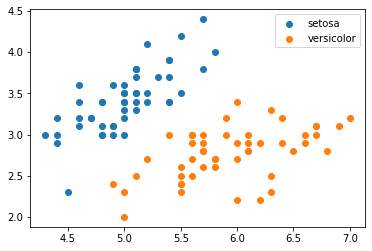

In [19]:
plt.figure()
for label in np.unique(y):
    plt.scatter(x[:,0][y==label],x[:,1][y==label], label = data.target_names[label])
plt.legend()
plt.show()

Now we need a function that predicts the logistic regression model and make predictions. This function takes a measurement, the current bias and the weights as input.

$$ z(x) = \frac{1}{1+e^{-(b_0 + \theta_0x_1 + \theta_1 x_2)}} $$


In [20]:
def z_x(x, bias, weights):
    """ param x: vector containing measurements. x = [x1, x2]
        param bias: single value
        param weight: vector containing model weights. weights= [w1,w2]
        
        return: value of logistic regression model for defined x, bias and weights
    """
    terms = []
    for x_i, w_i in zip(x,weights):
        terms.append(w_i*x_i)
    exponents = bias+sum(terms)
    return 1/(1+np.exp(-exponents))



Now try it with some random weights and bias

In [21]:
bias = np.random.normal()
weights = np.random.normal(size = len(x[0]))

predicted = []
for i in range(len(x)):
    yhat = z_x(x[i], bias, weights)
    predicted.append(round(yhat))

print('Accuracy: ', np.sum(np.equal(y,predicted)) / len(predicted))

Accuracy:  0.5


lets plot the decision boundary between the points for this set of weights. The decision boundary is found by setting z(x) = 0 which gives:

$$ x_2 = -\frac{b_0 + \theta_0x_1}{\theta_1} $$

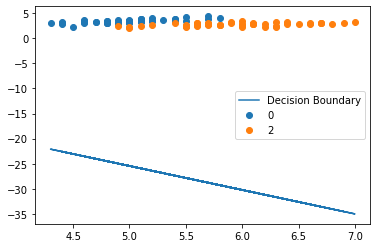

In [22]:
x_values = x[:,0]
y_values = - (bias + weights[0]*x_values) / weights[1]
plt.figure()
plt.scatter(x[:,0][y==0],x[:,1][y==0], label = '0')
plt.scatter(x[:,0][y==1],x[:,1][y==1], label = '2')
plt.plot(x_values, y_values, label='Decision Boundary')
plt.legend()
plt.show()

Not very good (or did you get lucky with the weights?). Try rerunning it a couple of times to see if you can randomly find a better set of weights that improves the accuracy.

Now, a better way of finding the optimal weights is the gradient descent method. Gradient descent is an iterative process of minimizing a function by following the gradients of a pre defined cost function. This is useful for updating and tuning the parameters of our logistic regression model. The updates are defined as:

$$ \theta_j \leftarrow \theta_j - \alpha \frac{\partial J(\theta)}{\partial\theta_j} $$

and similarily for the bias term 

$$ \theta_j \leftarrow b_0 - \alpha \frac{\partial J(b_0)}{\partial b_o} $$

where $\alpha$ is a user specified learning rate, controlling the step size of each update and $J(\theta)$ is the cost function. Hence, to minimize the cost function, we move in the direction opposite to the gradient.

We need to define a cost function and for binary classifications Binary-Cross-Entropy Loss Function is a good choise. Binary-Cross-Entropy is defined as 

$$
J(\theta)=
\begin{cases}
-log(g(x)),& \text{if } y = 1\\
-log(1 - g(x)),& \text{if } y = 0
\end{cases}
$$

where y is the target class. The Binary-Cross-Entropy tells us that if the target is 1 and we predict 0, then we will get a large error ($-log(0) = \infty$) and vice verca ($-log(1 - 1) = -log(0) = \infty$).

The two functions can be combined into one as:
$$ J(\theta)= -y\cdot log(z(x)) - (1-y)\cdot log(1-z(x))$$

For gradient descent we need the derivative of this cost function with respect to the weights $\frac{\partial J(\theta)}{\partial\theta_j}$. We can get this with the chain rule:

$$ \frac{\partial J(\theta)}{\partial\theta_j} = \frac{\partial J(\theta)}{\partial z(x)} \cdot \frac{\partial z(x)}{\partial h(x)} \cdot \frac{\partial h(x)}{\partial \theta}$$

Where the three derivatives result in:
$$\frac{\partial J(\theta)}{\partial z(x)} =  -(\frac{y}{z(x)} - \frac{(1-y)}{(1-z(x)}$$
$$\frac{\partial z(x)}{\partial h(x)} = z(x)\cdot(1-z(x))$$
$$\frac{\partial h(x)}{\partial \theta} =  x$$

which combined gives 

$$ \frac{\partial J(\theta)}{\partial\theta} = x\cdot(z(x)-y) $$

for the bias term the derivative is similar but it's not dependent on x since $\frac{\partial h(x)}{\partial b_0} =  1$

$$ \frac{\partial J(b_0)}{\partial b_0} = z(x)-y $$

The full algorithm is:
1. initialize the weights randomly 
2. Calculate the gradients of cost function w.r.t parameters
3. Update the weights by $ \theta_j \leftarrow \theta_j - \alpha \frac{\partial}{\partial\theta_j}J(\theta) $
4. Update the bias by $ b_0 \leftarrow b_0 - \alpha \frac{\partial}{\partial b_0}J(b_0) $
5. repeat until value of cost function does not change or to a pre-defined number of iterations

------------------------------------------------------------
NOTE that 

$$
Loss = -\frac{1}{n}\sum_{i=1}^ny_i*log(\hat{y}_i)+(1-y_i)*log(1-\hat{y}_i)
$$
$ y_i = $ target value <br>
$ \hat{y}_i = $ model output value

------------------------------------------------------------

Write a function for the cost and one for its derivative with respect to the weights and one with respect to the bias. Note that the derivative function will return the number of values corresponing the the number of weights that you have    

In [23]:
def cost_function(y, x, bias, weights):
    """ param y: Ground truth label for measurements
        param x: vector containing measurements. x = [x1, x2]
        param bias: single value
        param weight: vector containing model weights. weights= [w1,w2]
    
        return: value of the cost function. In this case BCE (binary cross entropy)
    """
    #Loss = -\frac{1}{n}\sum_{i=1}^ny_i*log(\hat{y}_i)+(1-y_i)*log(1-\hat{y}_i)
    #https://peltarion.com/knowledge-center/documentation/modeling-view/build-an-ai-model/loss-functions/binary-crossentropy
    n = len(x)
    loss_array = []
    for i in range(n):
        zi = z_x(x[i],bias,weights)
        ei = y[i]*np.log(zi)+(1-y[i])*np.log(1-zi)
        loss_array.append(ei)
    cost = (-1/n)*np.sum(loss_array)

    return cost


$$ \frac{\partial J(\theta)}{\partial\theta_j} = \frac{\partial J(\theta)}{\partial z(x)} \cdot \frac{\partial z(x)}{\partial h(x)} \cdot \frac{\partial h(x)}{\partial \theta}$$

Where the three derivatives result in:
$$\frac{\partial J(\theta)}{\partial z(x)} =  -(\frac{y}{z(x)} - \frac{(1-y)}{(1-z(x)}$$
$$\frac{\partial z(x)}{\partial h(x)} = z(x)\cdot(1-z(x))$$
$$\frac{\partial h(x)}{\partial \theta} =  x$$

In [24]:
def derivative_weights(y, x, bias, weights):
    """ param y: Ground truth label for measurements
        param x: vector containing measurements. x = [x1, x2]
        param bias: single value
        param weight: vector containing model weights. weights= [w1,w2]
    
        return: derivative of cost function with respect to the weights, dw = [dw1, dw2]
    """
    dw = []
    for j in range(len(weights)):
        deriv_sum = []
        for i in range(len(x)):
            x_i = x[i]
            #h_i = bias + sum([x*w for x,w in zip(x_i,weights)]) #b+theta0*x0+theta1*x1
            h_i = z_x(x_i, bias, weights)
            deriv_sum.append((h_i-y[i])*x_i[j])
        dw_j = sum(deriv_sum)/len(x)
        dw.append(dw_j)
    cost_deriv = dw
    return cost_deriv

In [25]:
def derivative_bias(y, x, bias, weights):
    """ param y: Ground truth label for measurements
        param x: vector containing measurements. x = [x1, x2]
        param bias: single value
        param weight: vector containing model weights. weights= [w1,w2]
    
        return: derivative of cost function with respect to the bias
    """
    deriv_sum = []
    n = len(x)
    for i in range(n):
        deriv_sum.append(z_x(x[i],bias,weights) - y[i])
    cost_deriv = sum(deriv_sum)/n

    return cost_deriv

Finally lets fit the logistic regression model with gradient descent. Gradient descent works by, at each iteration, average the total cost and the derivatives on over the full training set like:

$$  J(\theta)=\frac{1}{M}\sum_i^M -y\cdot log(z(x_i)) - (1-y_i)\cdot log(1-z(x_i))$$
$$  \frac{\partial J(\theta)}{\partial\theta_j} = \frac{1}{M}\sum_i^M x_i\cdot(z(x_i)-y_i) $$

Now we have everything we need to do gradient descent for logistic regression, remember the algorithm for gradient descent is:
1. initialize the weights randomly 
2. Calculate the gradients of cost function w.r.t parameters
3. Update the weights by $ \theta_j \leftarrow \theta_j - \alpha \frac{\partial}{\partial\theta_j}J(\theta) $
4. Update the bias by $ b_0 \leftarrow b_0 - \alpha \frac{\partial}{\partial b_0}J(b_0) $
5. repeat until value of cost function does not change or to a pre-defined number of iterations

Implement gradient descent for logistic regression. Save the current cost at each iteration and plot the cost at each iteration (Iteration on x-axis and Cost on y-axis)

In [26]:
lr = 0.002 #<-- specify learning rate ## I have no intuition of a good value here....

#initialize weights and bias as random
bias = np.random.normal()
weights = np.random.normal(size = len(x[0]))
print("old bias, weights:", bias, weights)


number_of_iterations = 500 #<-- number of iterations to perform gradient descent

#Loop through training data and update the weights at each iteration

for it in range(number_of_iterations):
# .. Code for gradient descent for logistic regression
    new_weights =  weights - derivative_weights(y, x, bias, weights) 
    new_bias = bias - lr*derivative_bias(y, x, bias, weights)
    weights = new_weights
    bias = new_bias

    cost = cost_function(y,x,bias,weights)
    #clear_output(wait=True) # This is used to clear the output for cleaner printing, can be removed if it causes trouble.
    if it == number_of_iterations:
        print('iteration: ', it, ' cost: ', cost) # In this case the variable for the current cost is called "cost"
print("new bias, weights:", bias, weights)

old bias, weights: -0.400304640506918 [-1.97725237 -1.50251067]
new bias, weights: -0.40386277960363975 [  6.13197107 -10.60321813]


In [27]:
predicted = []
for i in range(len(x)):
    yhat = z_x(x[i], bias, weights)
    predicted.append(round(yhat))

print('Accuracy: ', np.sum(np.equal(y,predicted)) / len(predicted))

Accuracy:  0.99


Lets plot the decision boundary for the new weights

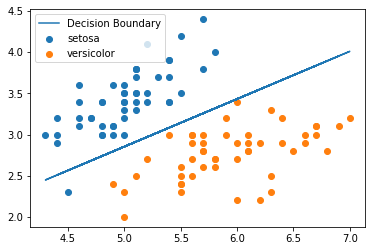

In [28]:
x_values = x[:,0]
y_values = - (bias + weights[0]*x_values) / weights[1]

plt.figure()
for label in np.unique(y):
    plt.scatter(x[:,0][y==label],x[:,1][y==label], label = data.target_names[label])
plt.plot(x_values, y_values, label='Decision Boundary')
plt.legend()
plt.show()

---

Teodor Carlsson<br>
Theoretical Assignment 2

---